# Gathering data

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from pathlib import Path

In [2]:
# Retrieve the 'AZURE_SEARCH_KEY' environment variable value using Python's os module.
key = os.environ.get('AZURE_SEARCH_KEY', 'fa628bcbbf504c87bf6525ab584a1d48')

In [3]:
# Use the search_images_bing function with the API key and the query 'dog' to search for images related to dogs.
results = search_images_bing(key, 'dog')

# Extract the 'content_url' attribute from each item in the search results to get the URLs of the images.
ims = results.attrgot('content_url')

# Determine the number of image URLs extracted and store it in the variable 'len(ims)'.
len(ims)

150

The output 150 indicates that the search_images_bing function retrieved 150 image URLs related to the search term 'dog'. These URLs are stored in the ims list, and the len(ims) function call is used to count the number of items (URLs) in this list.

In [4]:
# Define a tuple containing the strings 'Goldendoodle', 'Morkie', and 'Shih Tzu', representing different types of dogs.
dog_types = 'Goldendoodle', 'Morkie', 'Shih Tzu'

# Create a Path object from the pathlib library, pointing to a directory named 'dogs'.
path = Path('dogs')

In [5]:
# Check if the 'dogs' directory does not exist.
if not path.exists():
    # If the directory does not exist, create it.
    path.mkdir()
    # Iterate over each dog type in the dog_types tuple.
    for o in dog_types:
        # For each dog type, create a subdirectory in the 'dogs' directory.
        dest = (path/o)
        dest.mkdir(exist_ok=True)  # The exist_ok=True argument prevents an error if the directory already exists.
        # Search for images of the current dog type using the Bing search API.
        results = search_images_bing(key, f'{o} dog')
        # Download the images to the respective subdirectory. The URLs of the images are obtained from the 'contentUrl' attribute of the search results.
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(path)
fns

(#434) [Path('dogs/Goldendoodle/385f41b6-785c-45bb-a02a-79f379e693ec.jpg'),Path('dogs/Goldendoodle/4c7a6218-ebd2-4bdb-a254-3aec4d9c9c96.jpg'),Path('dogs/Goldendoodle/962adb3f-9d30-4fe8-a317-875b3a74fa7e.jpg'),Path('dogs/Goldendoodle/1be902f0-6f37-46d9-a61f-3388210dea5d.jpg'),Path('dogs/Goldendoodle/1664b827-6764-4a0c-8edd-dfe83a1d9184.jpg'),Path('dogs/Goldendoodle/7a5e338d-3968-43a1-b679-add950372a5d.jpg'),Path('dogs/Goldendoodle/ef2f3d1e-4adb-45b6-9b90-1b12e4964da0.jpg'),Path('dogs/Goldendoodle/0f998242-2fc2-402c-becd-bab05520a834.jpg'),Path('dogs/Goldendoodle/52e3b5ad-b0d5-4ab4-bd30-bb6d0b16fd06.jpg'),Path('dogs/Goldendoodle/dc7a0a8d-0645-4c32-bd59-5d8416a6244e.jpg')...]

# Clean data

In [8]:
failed = verify_images(fns)
failed

(#2) [Path('dogs/Goldendoodle/d3c20678-a2eb-4879-8c53-fdfb4193d4ce.jpg'),Path('dogs/Morkie/2a815a24-418e-436b-b890-368aebafa1ca.jpg')]

In [9]:
# For each item in the 'failed' collection, apply the Path.unlink method. 
# This will delete the file at the path specified by each item in 'failed', effectively removing any failed downloads or invalid image files.
failed.map(Path.unlink);

# Dataloader

In [10]:
# Create a DataBlock for processing image data, specifying the structure and data augmentation/preparation steps.
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
dls = dogs.dataloaders(path)

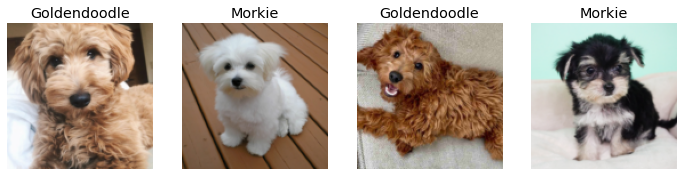

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

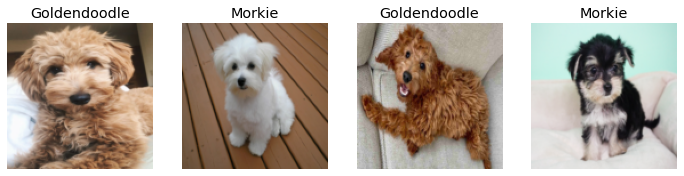

In [13]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

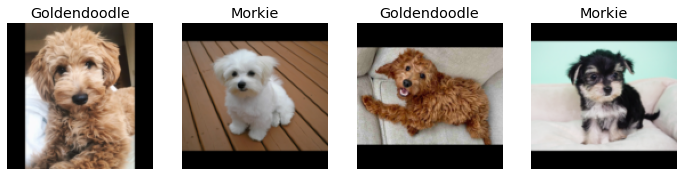

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

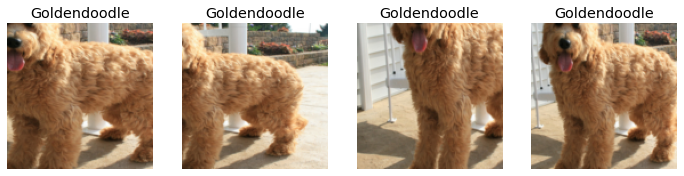

In [15]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [16]:
# dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
# dls = dogs.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
# dogs = dogs.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dls = dogs.dataloaders(path)

# Training Model, and Using It to Clean Your Data

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/minjae/opt/anaconda3/lib/python3.9/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.665479,0.143812,0.058140,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.732910,0.154883,0.069767,00:15
1,0.597074,0.095587,0.046512,00:15
2,0.471833,0.100516,0.058140,00:15
3,0.412862,0.117530,0.058140,00:15


These tables show the progress of training a machine learning model over several epochs, specifically in the context of image classification. Here's a breakdown of each metric and the observed trends over the epochs:

1. Epoch: Indicates the number of complete passes through the entire training dataset. The first table shows the result after the initial epoch (0), and the second table shows additional training starting again from epoch 0 and progressing to epoch 3.

2. Train Loss (train_loss): This is the model's loss (error) on the training dataset. It's a measure of how well the model is fitting the data. Over the epochs, we expect this number to decrease as the model learns. From the tables, train loss decreases consistently from 1.733078 in the initial epoch to 0.408569 by the third epoch in the second training session, indicating the model is increasingly fitting the training data well.

3. Validation Loss (valid_loss): This is the model's loss on the validation dataset, which is not used during training and serves to evaluate how well the model generalizes to unseen data. A decreasing validation loss, as seen from 0.593205 to 0.176940, suggests improving generalization.

4. Error Rate: This represents the proportion of incorrect predictions on the validation set. It decreased from 0.164706 (16.47%) in the initial epoch to 0.047059 (4.71%) by the end of the third epoch in the second session, indicating that the model's predictive accuracy is improving.

5. Time: This column shows the time taken for each epoch. Each epoch across the sessions took approximately 15 seconds, indicating consistent computational effort per epoch.

## Interpretation:

* The model shows consistent improvement across the metrics as training progresses. Lower losses and error rates indicate better performance.
* The reduction in both training and validation loss suggests that the model is learning effectively and not just memorizing the training data but generalizing well to new, unseen data.
* The decreasing error rate indicates that the model's predictions are becoming more accurate over time.
* The consistent time per epoch indicates stable computational performance across the training process.
* Overall, the model is on a positive trajectory, with improvements in fitting the training data and generalizing to validation data, which is reflected in the lower error rates over time.

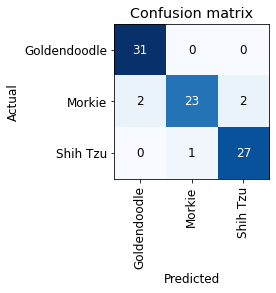

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

* Rows (Actual): Represent the actual classes of the data as they are in the test set.
* Columns (Predicted): Represent the classes that the model predicted.

## The matrix shows counts of:
* True Positives (Diagonal): The number of instances that were correctly classified for each class. For example, there are 31 Goldendoodles that were correctly identified as Goldendoodles, 29 Morkies correctly identified as Morkies, and 21 Shih Tzus correctly identified as Shih Tzus.
* False Positives and False Negatives (Off-Diagonal): Instances where the model made incorrect predictions. In this case, there are 3 instances where Morkies were misclassified as Goldendoodles and 1 instance where a Morkie was misclassified as a Shih Tzu. There are no instances where Goldendoodles or Shih Tzus were misclassified as another breed.

There are no instances where Shih Tzus were misclassified as Goldendoodles or Morkies, nor were Goldendoodles misclassified as Morkies or Shih Tzus.

## To summarize:
* The model is very good at identifying Goldendoodles and Shih Tzus, with no misclassifications.
* The model has a small confusion between Morkies and the other two breeds, with Morkies sometimes being misclassified as either Goldendoodles or Shih Tzus.
* The overall error rate is low, indicating the model performs well in differentiating among the three dog breeds.

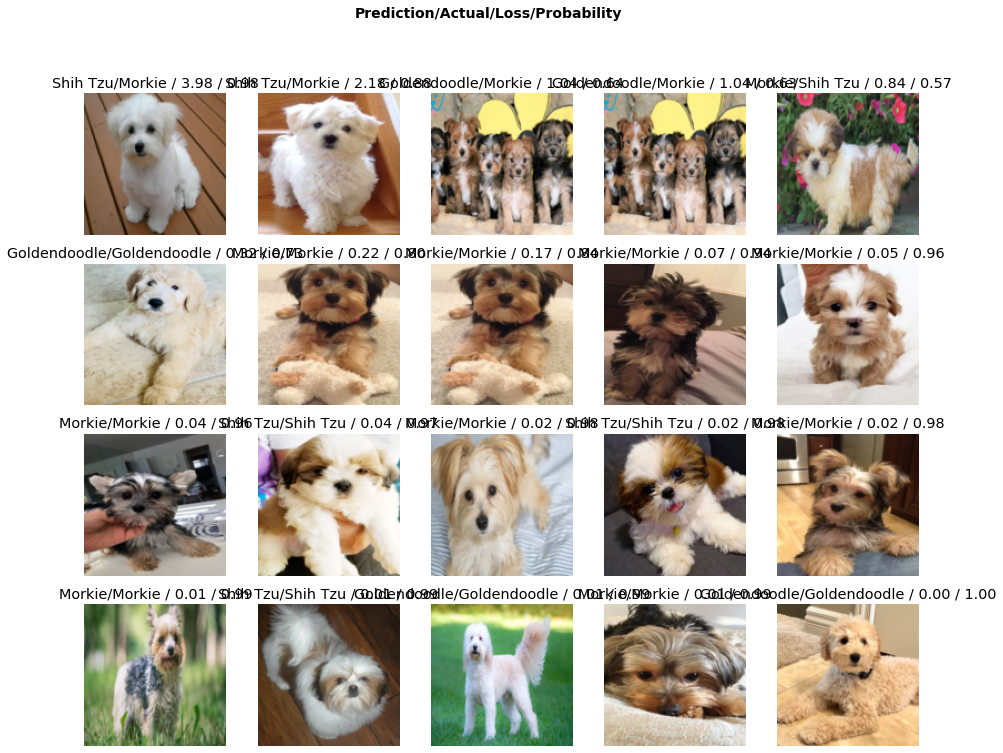

In [20]:
interp.plot_top_losses(20, nrows=4)

In [21]:
cleaner = ImageClassifierCleaner(learn, max_n=150)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Save model

In [23]:
learn.export('dog.pkl')

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('dog.pkl')]

In [25]:
learn = load_learner('dog.pkl')